# Clase 20 - Interpretabilidad II 🧐

- MDS7202: Laboratorio de Programación Científica para Ciencia de Datos


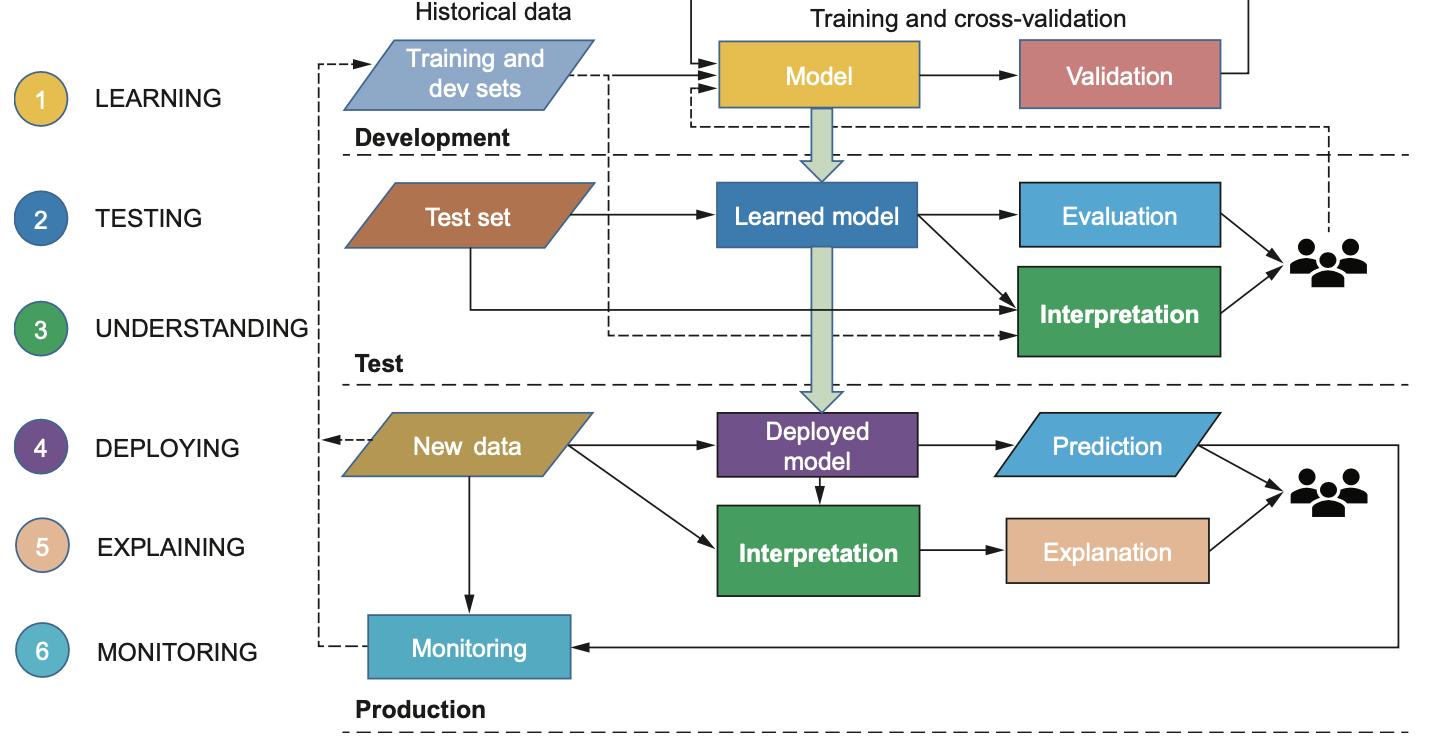

## Objetivos

- Comprender modelos agnosticos que permiten obtener explicaciones locales.
- Ver potenciales aplicaciones de Shap.

## Dataset

Para esta clase ocuparemos el dataset `credit_risk.csv`, el cual contiene una muestra de datos bancarios de diferentes personas. De esta forma, el problema se puede dividir en 2 partes:

- Entrenar un modelo que prediga la si un cliente será o no pagador.
- A partir del modelo entrenado, obtener insights para explicar su funcionamiento.

Para esta clase nos enfocaremos en la parte de **interpretabilidad**.

In [ ]:
import pandas as pd

path = "../../recursos/2023-01/25_interpretacion_II/credit_risk.csv"
df = pd.read_csv(path, index_col=0)
df.head()

## Modelos Agnosticos Locales

Los métodos locales de interpretabilidad en machine learning (ML) se centran en explicar las predicciones de un modelo para un único punto de datos o un pequeño subconjunto de puntos de datos. Esto contrasta con los métodos globales, que intentan explicar las predicciones del modelo para todo el conjunto de datos.

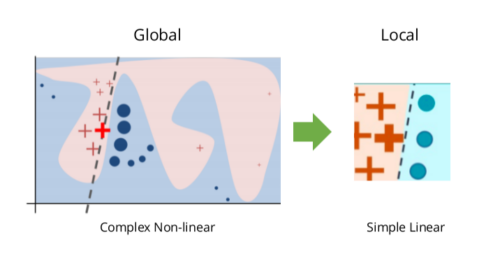

Los métodos locales suelen utilizarse cuando es importante entender por qué un modelo ha hecho una predicción concreta para un punto de datos específico. Por ejemplo, un médico podría querer entender por qué a un paciente se le diagnosticó una enfermedad concreta, o un analista financiero podría querer entender por qué el precio de una acción subió o bajó.

**Es importante** tener en cuenta que estos métodos son sólo **aproximaciones** a las verdaderas razones de las predicciones de un modelo. Además, los métodos locales pueden ser **costosos desde el punto de vista computacional** y es posible que no puedan explicar las predicciones de todos los modelos.

### Tipos de métodos locales

**Modelos sustitutos locales**: Estos métodos crean un modelo simple e interpretable que se aproxima a las predicciones de un modelo complejo para un único punto de datos. Esto puede hacerse encontrando un modelo lineal que se aproxime a las predicciones del modelo de caja negra para el punto de datos.

**Importancia local de las características**: Estos métodos calculan la importancia de cada característica en el modelo para un único punto de datos. Esto puede hacerse midiendo cuánto cambia la predicción cuando se modifica la característica.

## Scoped Rules (Anchors)

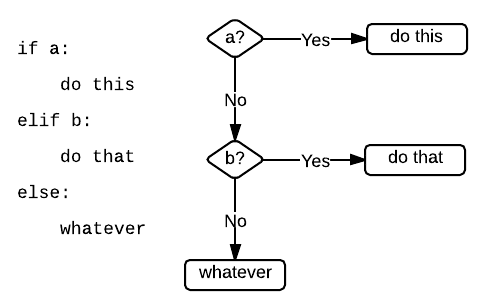

Las reglas de alcance, también conocidas como **anchors** (anclas en español), son un tipo de método de interpretabilidad local que explica las predicciones de un modelo para un único punto de datos. Los anclajes se crean encontrando **reglas de decisión** que "anclen" suficientemente la predicción. Una regla ancla una predicción si los cambios en los valores de otras características no afectan a la predicción.

### ¿Como funciona?

Los anclajes se crean mediante un algoritmo de reinforcement-learning multi-armed bandit. Los pasos son:

- El algoritmo empieza generando aleatoriamente un gran número de reglas. 
- A continuación, el algoritmo evalúa cada regla prediciendo la etiqueta del punto de datos utilizando el modelo y la regla. 
- El algoritmo se queda con las reglas que tienen la mayor precisión de predicción.

Finalmente, el algoritmo repite el proceso, pero esta vez sólo tiene en cuenta las reglas que se mantuvieron en la ronda anterior. El algoritmo sigue repitiendo este proceso hasta que encuentra un conjunto de reglas que anclan suficientemente la predicción.

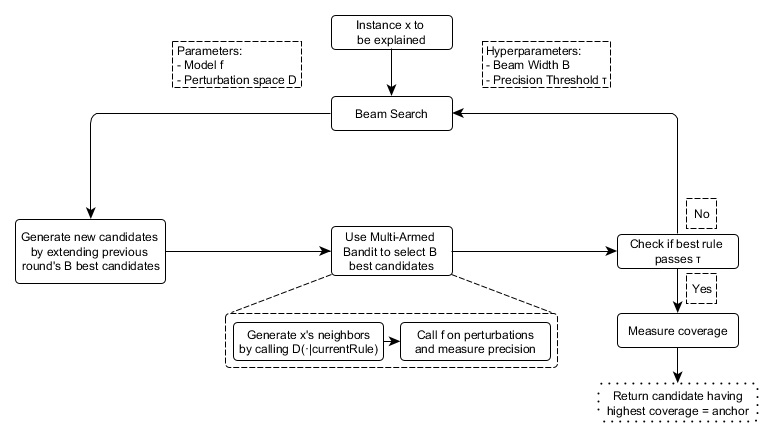

### Ejemplo

| Feature           | Valor  |
|-------------------|--------|
| Sexo              | M      |
| dinero_depositado | 30M    |
| Raza              | Asian  |
| ...               | ...    |
| Target            | Fraude |

*IF SEXO = M AND Raza = Asian AND dinero_depositado >= 20M THEN PREDICT Target = Fraude WITH PRECISION 97% AND COVERAGE 15%*

### ¿Coverage y Precision?

**El Coverage** (o cobertura) en las Anchors se refiere a la proporción de puntos de datos de un conjunto de datos que se explican por un anchor. El coverage de una anchor es importante porque indica hasta qué punto el anchor puede explicar las predicciones del modelo para otros puntos de datos.

Una anchor de alta cobertura tiene más probabilidades de ser útil para comprender las predicciones del modelo. **Un anchor de baja cobertura puede ser menos útil porque puede que sólo explique las predicciones del modelo para un pequeño número de puntos de datos**.

La cobertura de un ancla puede calcularse dividiendo el número de puntos de datos que explica la anchor, por el número total de puntos de datos del conjunto de datos. Por ejemplo, si una anchor explica 100 puntos de datos en un conjunto de datos de 1000 puntos de datos, la cobertura del ancla es del 10%.

**La cobertura de un anclaje puede verse afectada por varios factores**, como el tamaño del conjunto de datos, la complejidad del modelo y el número de reglas del anclaje. En general, los conjuntos de datos más grandes, los modelos más sencillos y un menor número de reglas darán lugar a anclas de mayor cobertura.

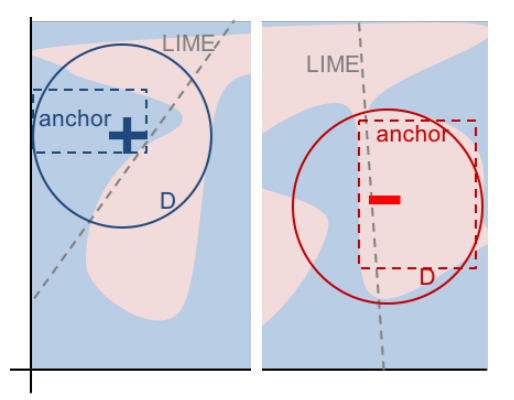

La **precisión** de una anchor es la fracción de puntos de datos que la anchor explica correctamente. **Una anchor con alta precisión tiene más probabilidades de ser exacta y útil para comprender las predicciones del modelo**.

La precisión puede calcularse dividiendo el número de puntos de datos explicados correctamente por la anchor entre el número total de puntos de datos explicados por el anclaje. Por ejemplo, si una anchor explica correctamente 10 puntos de datos de los 100 que explica, la precisión del anchor es del 10%.

### Consideraciones

**Si el conjunto de entrenamiento está desbalanceado, el espacio de perturbación también lo está**. Esta condición afecta a la búsqueda de reglas y a la precisión que podrían tener los resultados.

### Ventajas
- Facil de interpretar.
- Funciona cuando las predicciones del modelo no son lineales o son complejas en la vecindad de una instancia.
- Es altamente eficiente y puede ser paralelizado el proceso de busqueda de interpretabilidad. (en el papel)

### Desventajas
- Aveces necesita un ajuste de sus parámetros para entregar buenos resultados.
- Muchos escenarios requieren una discretización, ya que de lo contrario los resultados son demasiado específicos, tienen poca cobertura y no contribuyen a la comprensión del modelo.
- Tiene muchas llamadas al modelo de ML entrenado.
- La cobertura no esta bien definida en algunos dominios (especificamente en imagenes).

### Ejemplo en Python

In [ ]:
# pip install alibi

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from alibi.explainers import AnchorTabular
from alibi.datasets import fetch_adult

import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# recordemos como se ven los datos
df.head()

In [ ]:
# separar datos 
X = df[df.columns[0:10]] #.drop(columns=['user', 'target_value', 'year', 'month'])
y = df['target_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
# entrenar modelo
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

In [ ]:
# generar predicciones
preds = clf.predict(X_test)
print(classification_report(preds, y_test))

Implementemos ahora `Anchors` para interpretar el modelo entrenado:

In [ ]:
predict_fn = lambda x: clf.predict(x) # creamos función de predicción
explainer = AnchorTabular(predict_fn, clf.feature_names_in_, seed=1) # instanciamos Anchor usando función creada
explainer.fit(X_train.to_numpy()) # sobre los datos

In [ ]:
idx = 5 # índice obs a predecir
obs = np.array(X_test.iloc[idx], ndmin = 2) # array de la obs

explanation = explainer.explain(obs, threshold=0.95) # generar anchor
print('Prediction: ', explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]) # obtener prediccion del modelo 
print('Anchor: %s' % (' AND '.join(explanation.anchor))) # obtener regla 
print('Precision: %.2f' % explanation.precision) # obtener precision
print('Coverage: %.2f' % explanation.coverage) # obtener cobertura

In [ ]:
idx = 13 # índice obs a predecir
obs = np.array(X_test.iloc[idx], ndmin = 2) # array de la obs

explanation = explainer.explain(obs, threshold=0.95) # generar anchor
print('Prediction: ', explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]) # obtener prediccion del modelo 
print('Anchor: %s' % (' AND '.join(explanation.anchor))) # obtener regla 
print('Precision: %.2f' % explanation.precision) # obtener precision
print('Coverage: %.2f' % explanation.coverage) # obtener cobertura

## Shap

![](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

Propuesto en 2017 por Lundberg y Lee, esté es uno de los métodos más utilizados actualmente en la industría (reemplazo directo de LIME).



El método de las explicaciones aditivas de Shapley (SHAP) es un enfoque teórico de juegos para explicar el resultado de un modelo de aprendizaje automático. Funciona considerando todas las posibles coaliciones de características y asignando a cada característica un valor de Shapley, que mide la **contribución** de esa característica al resultado del modelo.

¿Como medimos la contribución de una característica?

### Contribución sobre Valor Base

Uno de los valores relevantes a la hora de calcular la contribución de cada feature es el **valor base**. El valor base es el valor esperado de la salida de un modelo de aprendizaje automático si no tuviera información sobre las características. Se calcula promediando las predicciones del modelo en un gran conjunto de datos de ejemplos. El valor base se utiliza como **punto de referencia** para comprender cómo contribuyen las características de un ejemplo concreto a la predicción del modelo para ese ejemplo.

**Ejemplo**: consideremos un modelo que predice el precio de una casa. El valor base de este modelo sería el precio medio de todas las casas del conjunto de datos. Si el modelo predice que una casa en particular vale 300.000 dólares, los valores SHAP mostrarían cómo contribuye cada característica de esa casa a la diferencia entre la predicción del modelo y el valor base.

**El valor base es importante para entender los valores SHAP porque proporciona un contexto para interpretar los valores**. Sin el valor base, sería difícil saber si un valor SHAP es positivo o negativo. Por ejemplo, un valor SHAP positivo podría significar que la característica aumenta la predicción del modelo, o podría significar que la característica disminuye la predicción del modelo en una cantidad menor que el valor base.

El valor base también es importante para comprender cómo interactúan las características entre sí. Por ejemplo, consideremos un modelo que predice el riesgo de que un paciente desarrolle cáncer. El valor base de este modelo sería el riesgo medio de todos los pacientes del conjunto de datos. Si el modelo predice que un paciente concreto tiene un riesgo del 10%, los valores SHAP mostrarían cómo contribuye cada característica de ese paciente a la diferencia entre la predicción del modelo y el valor base.

Considerando lo anterior, los valores de shap pueden ser representados bajo la siguiente expresión:

$$\hat f(z) = \phi_0 + \sum_{j=1}^M \phi_j z'_j$$

donde $\phi_0$ puede ser interpretado como $E(\hat f(z))$.

### Cálculo de valores SHAP

Conceptualmente, los valores SHAP se calculan re entrenando el modelo en todos los subconjuntos posibles de características $S \subseteq F$, donde $F$ es el conjunto total de características (todos los atributos disponibles).

De esta manera, la idea entrenar un modelo con $f_{S \cup i}$ con la característica $i$ y otro modelo $f_S$ sin esta característica.

Con ambas salidas, es posible calcular la contribución de la feature $i$ como la resta entre ambos valores. Esto se repite para todos los subconjuntos posibles $S \subseteq F$ y luego se obtiene una agregación ponderada de la contribución.

La siguiente expresión resume lo expuesto:

$$\phi_i=\sum_{S \subseteq F \backslash\{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!}\left[f_{S \cup\{i\}}\left(x_{S \cup\{i\}}\right)-f_S\left(x_S\right)\right]$$

Pueden encontrar los detalles para calcular los shapley values en el siguiente [paper](https://proceedings.neurips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html).

### Propiedades

Dentro de las propiedades que posee shap podemos encontrar 4:

- **Eficiencia**: La suma de los valores SHAP de todas las características debe ser igual a la diferencia entre la predicción del modelo y el valor base (generalmente el promedio de las predicciones)

- **Precisión local**: los valores SHAP son localmente precisos, lo que significa que son precisos para una predicción concreta. Esto contrasta con las medidas de importancia de características globales, como la importancia de permutación, que son precisas para todo el conjunto de datos.

$$\hat{f}(x)=g(x´)=\phi_0 + \sum_{j=1}^M \phi_j x'_j$$

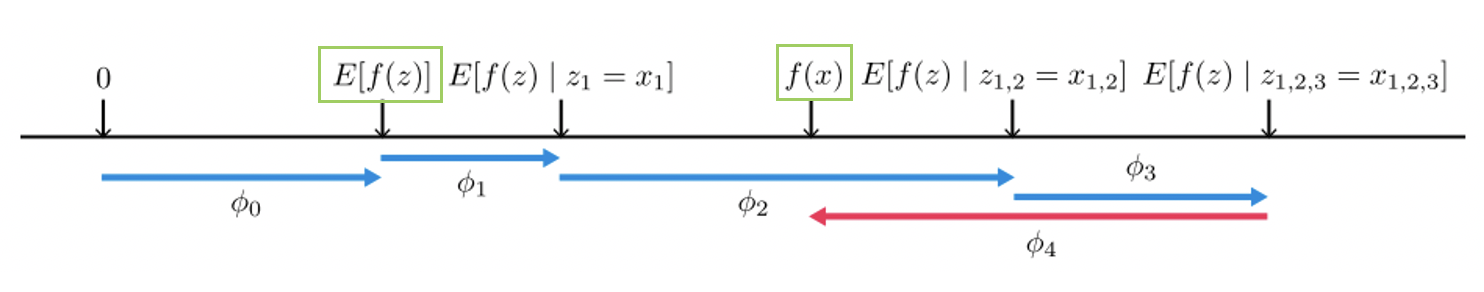

- **Missigness**: Los valores SHAP son capaces de explicar las predicciones de los modelos incluso cuando faltan características. Esto se debe a que los valores SHAP se calculan utilizando una representación lineal de las características, lo que les permite tener en cuenta los valores que faltan.

$$x_j'=0 \rightarrow \phi_j=0$$

- **Consistencia**: La propiedad de coherencia dice que si un modelo cambia de modo que la contribución marginal del valor de una característica aumenta o se mantiene igual (independientemente de otras características), el valor de Shapley también aumenta o se mantiene igual.

En otras palabras:

$$\phi_j(\hat{f´}, x) \geq \phi_j(\hat{f}, x)$$

Si dos modelos $f$ y $f'$ cumple:
$$\hat{f´}_x(z´) - \hat{f´}_x(z_j´) \geq \hat{f}_x(z´) - \hat{f}_x(z_j´)$$

        ❓ Pregunta: ¿Un ejemplo de esto?


<img src="https://gastronomiaycia.republica.com/wp-content/uploads/2021/05/truco_pinzasensalada_tarta2.jpg" width="250">

### Ventajas

- SHAP tiene una sólida base teórica en la teoría de juegos. 
- Método es agnóstico al modelo de predicción
- La predicción se distribuye equitativamente entre los valores de las características. 
- Obtenemos explicaciones contrastivas que comparan la predicción con la predicción media.
- SHAP dispone de una aplicación rápida para modelos basados en árboles.
- Su "rápida aplicación" permite generar explicaciones globales de los modelos.

### Desventajas

- El SHAP kernel tiende a ser lento cuando se tienen muchos datos.
- KernelSHAP ignora la dependencia de las características.
- TreeSHAP puede producir atribuciones de características poco intuitivas.

### Ejemplo en Python

In [ ]:
# pip install shap
import shap

In [ ]:
X = df.drop(columns=['user', 'target_value', 'year', 'month'])
y = df['target_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
# Head del conjunto de entrenamiento
X_train.head(5)

In [ ]:
# Dimensiones del dataframe
X_train.shape

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

In [ ]:
preds = clf.predict(X_test)
print(classification_report(preds, y_test))

Comencemos probando la interpretabilidad del modelo construido con los métodos que vienen por default:

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# weight: numbero de veces que una feature es usada para dividir la data
xgb.plot_importance(clf, max_num_features=20)
plt.title("Feature Importance con importance_type='weight'")
plt.show()

        ❓Pregunta: ¿Qué sucede con las importancias?

La importancia de XGBoost (y en general en modelos que utilizan árboles) se calcula en función del **número de veces que se utiliza una característica** para dividir un nodo en un árbol de decisión. Puede ser una medida útil de la importancia de una característica para la precisión global del modelo. Sin embargo, puede **inducir a error** en el caso de características con muchos valores posibles, ya que estas características pueden utilizarse con más frecuencia simplemente porque **hay más oportunidades de dividirlas**.

        ❓Pregunta: ¿Cómo se utiliza shap para calcular la importancia?

Primero comenzamos eligiendo el `explainer`, este debe ser coherente con el problema que estamos resolviendo, para este caso como estamos usando boosting, usamos árboles.

Pueden encontrar todos los explainers habilitados por la librería `shap` en el siguiente [link](https://shap.readthedocs.io/en/latest/api.html#explainers).

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

¿Qué incluye `shap_values`? - Con el explainer calcularemos los shap para cada uno de las instancias del modelo. 

In [ ]:
shap_values


En especifico, si revisamos `shap_values.values`, podemos ver que esta posee la siguiente dimensión:

In [ ]:
# Vemos el valor de la instancia x_1
shap_values.values[1,:].shape

Tendremos un valor para cada una de las features con las que fue entrenado el modelo.

In [ ]:
shap_values.values[1,:]

Los valores negativos señalan aportes negativos para detectar el target de interés que en este caso es la morosidad de los clientes a tres meses. Por otro lado, los positivos señalan variables que entregan un aporte positivo a la detección de la label 1 (morosidad a 3 meses).

Veamos ahora los valores base:

In [ ]:
shap_values.base_values

In [ ]:
shap_values.base_values.shape

> **Pregunta**: ¿Por qué estos valores no pertenecen al intervalo (0, 1)? 

In [ ]:
# transformar logits a probabilidad
np.exp(shap_values.base_values) / (1 + np.exp(shap_values.base_values))

Para ver los aportes de las diferentes variables utilizando shap se realiza lo siguiente:

In [ ]:
idx = 1

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

Notar que `link="logit"` se encargará de entregar una probabilidad en la salida. Por otro lado, de esta forma es mucho más simple visualizar los aportes de cada una de las variables para tomar la decisión en el output.

Veamos un segundo ejemplo:

In [ ]:
idx = 2

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

Una forma más intuitiva de generar este tipo de gráficos es de la siguiente forma:

In [ ]:
idx=2
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

In [ ]:
idx=23
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

Otra forma de hacer esto es con un batch de datos, para esto realizamos lo siguiente:

In [ ]:
explainer.expected_value

In [ ]:
batch_size = 10
shap.force_plot(explainer.expected_value, shap_values.values[:batch_size,:], X.iloc[:batch_size,:], link='logit')

Otra forma de hacer esto es realizando un mapa de calor...

In [ ]:
shap.plots.heatmap(shap_values[:batch_size])

¿Que pasa si quiero obtener la interpretabilidad global?

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
# Otra forma der ver el plot anterior es la siguiente
shap.summary_plot(shap_values, X)

¿Qué pasa si necesitamos obtener las variables más importantes en orden?

In [ ]:
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

In [ ]:
# Revisamos las features
feature_importance_names[:20]

Por otra parte, uno de los gráficos más interesantes es plotear la relación de los shap v/s las features entrantes del modelo:

In [ ]:
for name in feature_importance_names[:4]:
    shap.plots.scatter(shap_values[:,name])

La librería de `shap` nos habilita una opción para colorear los puntos usando la feature con mayor interacción a la feature del plot: 

In [ ]:
for name in feature_importance_names[:4]:
    shap.plots.scatter(shap_values[:,name],
                       color = shap_values)

Tenemos un problema con estos gráficos:

- Los valores extremos que presentan impiden visualizar el comportamiento de valores superiores a cero. 
- Además, tendríamos graficos mas interpretables si pudiésemos elegir la variable para colorear

Resolvamos lo anterior:

In [ ]:
color = clf.predict(X) # predicción para todo el conjunto de datos

for name in feature_importance_names[:3]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                       color=color, # color por etiqueta predicha
                       xmin=0) # se agrega valor minimo = 0 para tener una mejor visualización

### PDP (¿denuevo?)

Punto interesante... Shap puede calcular las PDP de las variables 😃, o sea... es un reemplazante directo de gran parte de los métodos que vimos:

In [ ]:
X100 = shap.utils.sample(X, 100)

sample_ind = 20
shap.partial_dependence_plot(
    'balance_avg_3m_avg_trunc', clf.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:],
)